In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" 
  value="Click here to toggle on/off the raw code."></form>''')

#### Integrated Hydrology

This is a series of problems to test and demonstrate the integrated hydrology components of ATS.  Integrated hydrology consists of Richards equation in the subsurface coupled to a diffusion wave approximation on the surface system.  Coupling is done through assuming continuous pressure and flux across the surface-subsurface interface.

Tests demonstrate a 1D column (showing dry-to-wet and wet-to-dry transitions), a 2D "open book" problem (showing that water flows down hill) and a typical 2D "hillslope" problem comparable to the Sulis et al (WRR) benchmark problems.

Author: Ethan Coon

In [2]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import parse_xmf, parse_ats
import column_data, transect_data
import colors
import mesh
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar

In the first example, we rain on a column for half a day, then turn off the rain.  A continuous, constant baseflow is applied as a sink at the bottom of the column.  Initially the column is partially saturated.  As rainfall > baseflow, the column saturates and ponded water expresses on the surface.  After rainfall stops, baseflow takes the water table below the surface again. 

This demonstrates reasonable performance in the dry-to-wet and wet-to-dry transitions.

In [3]:
# load the ATS solution
directory = "integrated_hydro-column.regression.gold"

dat = column_data.column_data(["saturation_liquid"], directory=directory)
keys, times, dats = parse_ats.readATS(directory, "visdump_surface_data.h5", timeunits='d')
pd = parse_ats.getSurfaceData(keys, dats, "ponded_depth")



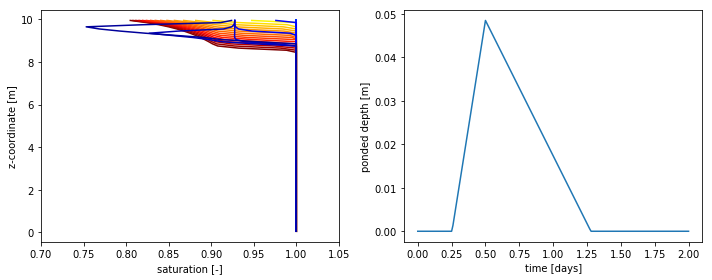

In [4]:
# plot the solution
z = dat[0,0,:]
cm = colors.cm_mapper(0,dat.shape[1]-1) # color the plots as a function of time
fig, axs = plt.subplots(1,2, figsize=(10,4))

for i in range(dat.shape[1]-1,0,-5):
    axs[0].plot(dat[1,i,:],z, color=cm(i))

axs[0].set_xlabel('saturation [-]')
axs[0].set_ylabel('z-coordinate [m]')
axs[0].set_xlim(0.7,1.05)

axs[1].plot(times, pd)
axs[1].set_xlabel("time [days]")
axs[1].set_ylabel("ponded depth [m]")

plt.tight_layout()
plt.show()

In the next example, we simply rain on a V-catchment in 2D, allowing the water to pond.  This simply demonstrates that water runs downhill (in a coupled environment).  Plots show saturation (in colors) and the ponded depth (a line above the catchment).  

At time zero, a water table is established.  Infiltration occurs through the 30 hour plot.  By 60 hours, the domain is saturated and water is ponding on the surface.

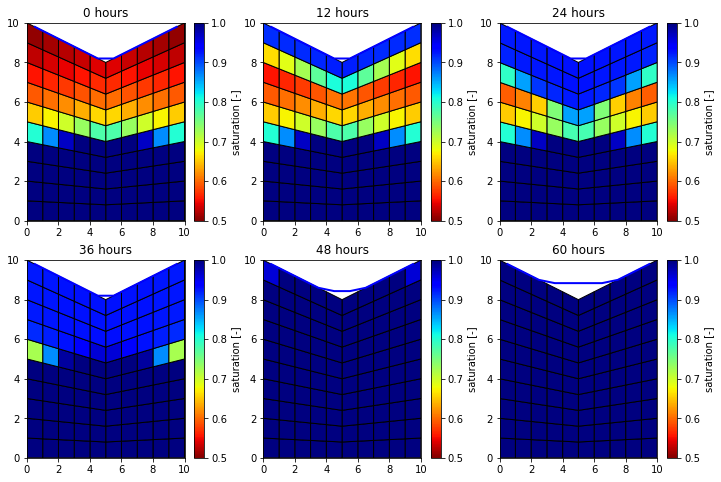

In [5]:
# plot the saturation at a few times
directory = "integrated_hydro-v.regression.gold"

keys, times, dat = parse_ats.readATS(directory, "visdump_data.h5", timeunits='d')
dats = column_data.column_data(['ponded_depth.cell.0','elevation.cell.0'], 
                               directory=directory, filename="visdump_surface_data.h5", 
                               mesh_filename="visdump_surface_mesh.h5", coord=0)

fig, axs = plt.subplots(2,3,figsize=(12,8))

def plot(i, ax):
    cax = colorbar.make_axes(ax, 'right')[0]
    cax.set_ylabel("saturation [-]")

    transect_data.plot(dat["saturation_liquid.cell.0"][keys[i]][:,0], ax, cax,
                       0.5, 1.0, directory=directory, cmap="jet_r", label="saturation [-]")
    ax.plot(dats[0,0,:], dats[1,i,:]+dats[2,i,:], 'b', linewidth=2)
    ax.set_title("{0} hours".format(3*i))
    
plot(0, axs[0,0])
plot(4, axs[0,1])
plot(8, axs[0,2])
plot(12, axs[1,0])
plot(16, axs[1,1])
plot(20, axs[1,2])

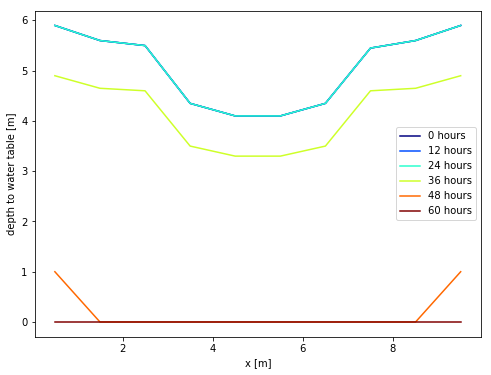

In [6]:
# plot the depth to water table as a function of time
#
# Note that the jaggedness of this plot is due
# a nonuniform mesh and sampling (discrete) issues.
#

directory = "integrated_hydro-v.regression.gold"
keys, times, dat = parse_ats.readATS(directory, "visdump_data.h5", timeunits='d')
col_dat = transect_data.transect_data(['saturation_liquid',], keys=np.s_[0:21:4], directory=directory)

nvar, nt, nx, nz = col_dat.shape

# z_surf and z_bott is extrapolated based on dz, and is not necessarily exact if 
# dz varies in the top (respectively bottom) two cells
z_surf = col_dat[1,0,:,-1] + (col_dat[1,0,:,-1] - col_dat[1,0,:,-2])/2.
z_bott = col_dat[1,0,:,0] - (col_dat[1,0,:,1] - col_dat[1,0,:,0])/2.

# Determine the index of the lowest unsaturated cell at each time and x coordinate.
# Note that this is the right choice for water table, as a saturated zone might exist 
# on TOP of an unsaturated zone, for a perched aquifer, so we DON'T want the highest 
# saturated cell.
wtd = np.nan * np.ones((col_dat.shape[1], col_dat.shape[2]),'d')
for i in range(nx):
    for k in range(nt):
        where_unsat = np.where(col_dat[2,k,i,:] < 1.0)[0]
        if len(where_unsat) == 0:
            # nothing is unsaturated
            wtd[k,i] = 0.
        elif where_unsat[0] == 0:
            # nothing is saturated, wtd is the full column thickness
            wtd[k,i] = z_surf[i] - z_bott[i]
        else:
            # wt is in the domain -- average the first unsaturated with the last 
            # saturated, then subtract from the surf to get depth
            wtd[k,i] = z_surf[i] - (col_dat[1,k,i,where_unsat[0]] + col_dat[1,k,i,where_unsat[0]-1])/2 

# plot
fig,ax = plt.subplots(1,1, figsize=(8,6))
cm = colors.cm_mapper(0,nt-1)
for k in range(nt):
    ax.plot(col_dat[0,0,:,0], wtd[k,:], color=cm(k), label="{0} hours".format(3*4*k))
ax.set_xlabel("x [m]")
ax.set_ylabel("depth to water table [m]")
ax.legend()
plt.show()